# バンド演算を行う

波長について概要を掴んだところで、続いては衛星が持つバンドの組み合わせについて理解をしましょう。

どのような波長データ（バンド）を持っているかは衛星ごとに異なります。この波長の組み合わせを変えてブレンドした画像を作ることで、写真で写した世界とは異なる状態を読み取れるようになります。正規化水指標（NDWI）を使えば画像の中で水がある場所を濃い色で、正規化積雪指標（NDSI）を使えば画像の中で雪のある場所を濃い色で強調できます。

＊目的とする対象の度合いを見えるような組み合わせを用いて比較できるよう正規化した指標のことを「正規化指標」と呼びます。



In [ ]:
# google driveをマウント
# Tellusの開発環境やローカル環境を使用する想定であれば、このセルは削除可です。
from google.colab import drive 
drive = drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 衛星データのダウンロード

Spatio Temporal Asset Catalog (STAC)経由でLandast 8のデータを取得します。最初に必要なライブラリのインストールを行います。

In [ ]:
!pip install geopandas
!pip install earthpy
!pip install rasterio
!pip install sentinelsat
!pip install cartopy
!pip install fiona
!pip install shapely
!pip install pyproj
!pip install pygeos
!pip install rtree
!pip install rioxarray
!pip install pystac-client sat-search
!pip install rich

In [ ]:
#必要ライブラリのインポート
import os
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams['figure.dpi'] = 300 # 解像度
import folium
import zipfile
import glob
import shutil
import cartopy, fiona, shapely, pyproj, rtree, pygeos
import cv2
import rasterio as rio
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask
# from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import MultiPolygon, Polygon
from osgeo import gdal

import urllib
from satsearch import Search
from pystac_client import Client
from PIL import Image
import requests
import io
from pystac_client import Client
import warnings
warnings.filterwarnings('ignore')

print("done")

done


鹿児島市周辺の画像を取得します。取得期間は2019年から2020年までとします。取得するSentinel-2はオルソ幾何補正大気圏下 (BOA) 反射率プロダクト（L2A）となります。Sentinel-2は可視光領域から近赤外、短波長赤外までを観測し、13のバンドで構成されたデータとなっています。

In [ ]:
# 取得範囲を指定するための関数を定義
def selSquare(lon, lat, delta_lon, delta_lat):
    c1 = [lon + delta_lon, lat + delta_lat]
    c2 = [lon + delta_lon, lat - delta_lat]
    c3 = [lon - delta_lon, lat - delta_lat]
    c4 = [lon - delta_lon, lat + delta_lat]
    geometry = {"type": "Polygon", "coordinates": [[ c1, c2, c3, c4, c1 ]]}
    return geometry

# 鹿児島市市周辺の緯度経度をbbox内へ
geometry = selSquare(130.53, 31.60, 0.06, 0.02)
timeRange = '2019-01-01/2020-12-31' # 取得時間範囲を指定

STACサーバに接続し、取得範囲・時期やクエリを与えて取得するデータを絞ります。sentinel:valid_cloud_coverを用いて、雲量の予測をより確からしいもののみに限定しています。

In [ ]:
api_url = 'https://earth-search.aws.element84.com/v0'
collection = "sentinel-s2-l2a-cogs"  # Sentinel-2, Level 2A (BOA)
s2STAC = Client.open(api_url, headers=[])
s2STAC.add_conforms_to("ITEM_SEARCH")

s2Search = s2STAC.search ( 
    intersects = geometry,
    datetime = timeRange,
    query = {"eo:cloud_cover": {"lt": 10}, "sentinel:valid_cloud_cover": {"eq": True}},
    collections = collection)

s2_items = [i.to_dict() for i in s2Search.get_items()]
print(f"{len(s2_items)} のシーンを取得")

64 のシーンを取得


In [ ]:
items = s2Search.get_all_items()
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:32652")
dfSorted = df.sort_values('eo:cloud_cover').reset_index(drop=True)
dfSorted.head()

,geometry,created,sentinel:product_id,sentinel:sequence,view:off_nadir,sentinel:valid_cloud_cover,platform,sentinel:utm_zone,proj:epsg,sentinel:grid_square,datetime,instruments,constellation,eo:cloud_cover,gsd,sentinel:latitude_band,sentinel:data_coverage,updated,data_coverage
0,"POLYGON ((131.210 31.528, 130.053 31.542, 130....",2020-08-18T23:02:38.459Z,S2B_MSIL2A_20200511T015701_N0214_R031_T52SFA_2...,0,0,True,sentinel-2b,52,32652,FA,2020-05-11T02:08:41Z,[msi],sentinel-2,0.01,10,S,100,2020-08-18T23:02:38.459Z,NaN
1,"POLYGON ((131.189 30.626, 130.044 30.641, 130....",2020-09-21T13:41:55.349Z,S2B_MSIL2A_20200206T015839_N0214_R060_T52RFV_2...,0,0,True,sentinel-2b,52,32652,FV,2020-02-06T02:08:45Z,[msi],sentinel-2,0.01,10,R,100,2020-09-21T13:41:55.349Z,100.0
2,"POLYGON ((131.210 31.528, 130.053 31.542, 130....",2020-08-19T00:31:29.236Z,S2A_MSIL2A_20200511T015701_N0214_R060_T52SFA_2...,1,0,True,sentinel-2a,52,32652,FA,2020-05-11T02:08:41Z,[msi],sentinel-2,0.01,10,S,100,2020-08-19T00:31:29.236Z,NaN
3,"POLYGON ((131.210 31.528, 130.053 31.542, 130....",2020-08-23T12:49:49.903Z,S2B_MSIL2A_20190919T015649_N0213_R060_T52SFA_2...,0,0,True,sentinel-2b,52,32652,FA,2019-09-19T02:08:35Z,[msi],sentinel-2,0.02,10,S,100,2020-08-23T12:49:49.903Z,NaN
4,"POLYGON ((131.189 30.626, 130.044 30.641, 130....",2020-09-21T05:59:54.601Z,S2B_MSIL2A_20191009T015659_N0213_R060_T52RFV_2...,0,0,True,sentinel-2b,52,32652,FV,2019-10-09T02:08:52Z,[msi],sentinel-2,0.05,10,R,100,2020-09-21T05:59:54.601Z,100.0


In [ ]:
def sel_items(scene_items, product_id):
  item = [x.assets for x in scene_items\
          if x.properties['sentinel:product_id'] == product_id]
  thumbUrl = [x.assets['thumbnail'].href for x in scene_items\
              if x.properties['sentinel:product_id'] == product_id]
  return item, thumbUrl

selected_item, thumbUrl = sel_items(items, dfSorted['sentinel:product_id'][0])
print(thumbUrl)
print(selected_item)

['https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/52/S/FA/2020/5/11/0/preview.jpg']
[{'thumbnail': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/52/S/FA/2020/5/11/0/preview.jpg>, 'overview': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/52/S/FA/2020/5/S2B_52SFA_20200511_0_L2A/L2A_PVI.tif>, 'info': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/52/S/FA/2020/5/11/0/tileInfo.json>, 'metadata': <Asset href=https://roda.sentinel-hub.com/sentinel-s2-l2a/tiles/52/S/FA/2020/5/11/0/metadata.xml>, 'visual': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/52/S/FA/2020/5/S2B_52SFA_20200511_0_L2A/TCI.tif>, 'B01': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/52/S/FA/2020/5/S2B_52SFA_20200511_0_L2A/B01.tif>, 'B02': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/52/S/FA/2020/5/S2B_52SFA_20200511_0_L2A/B02.tif>, 'B03': <Asse

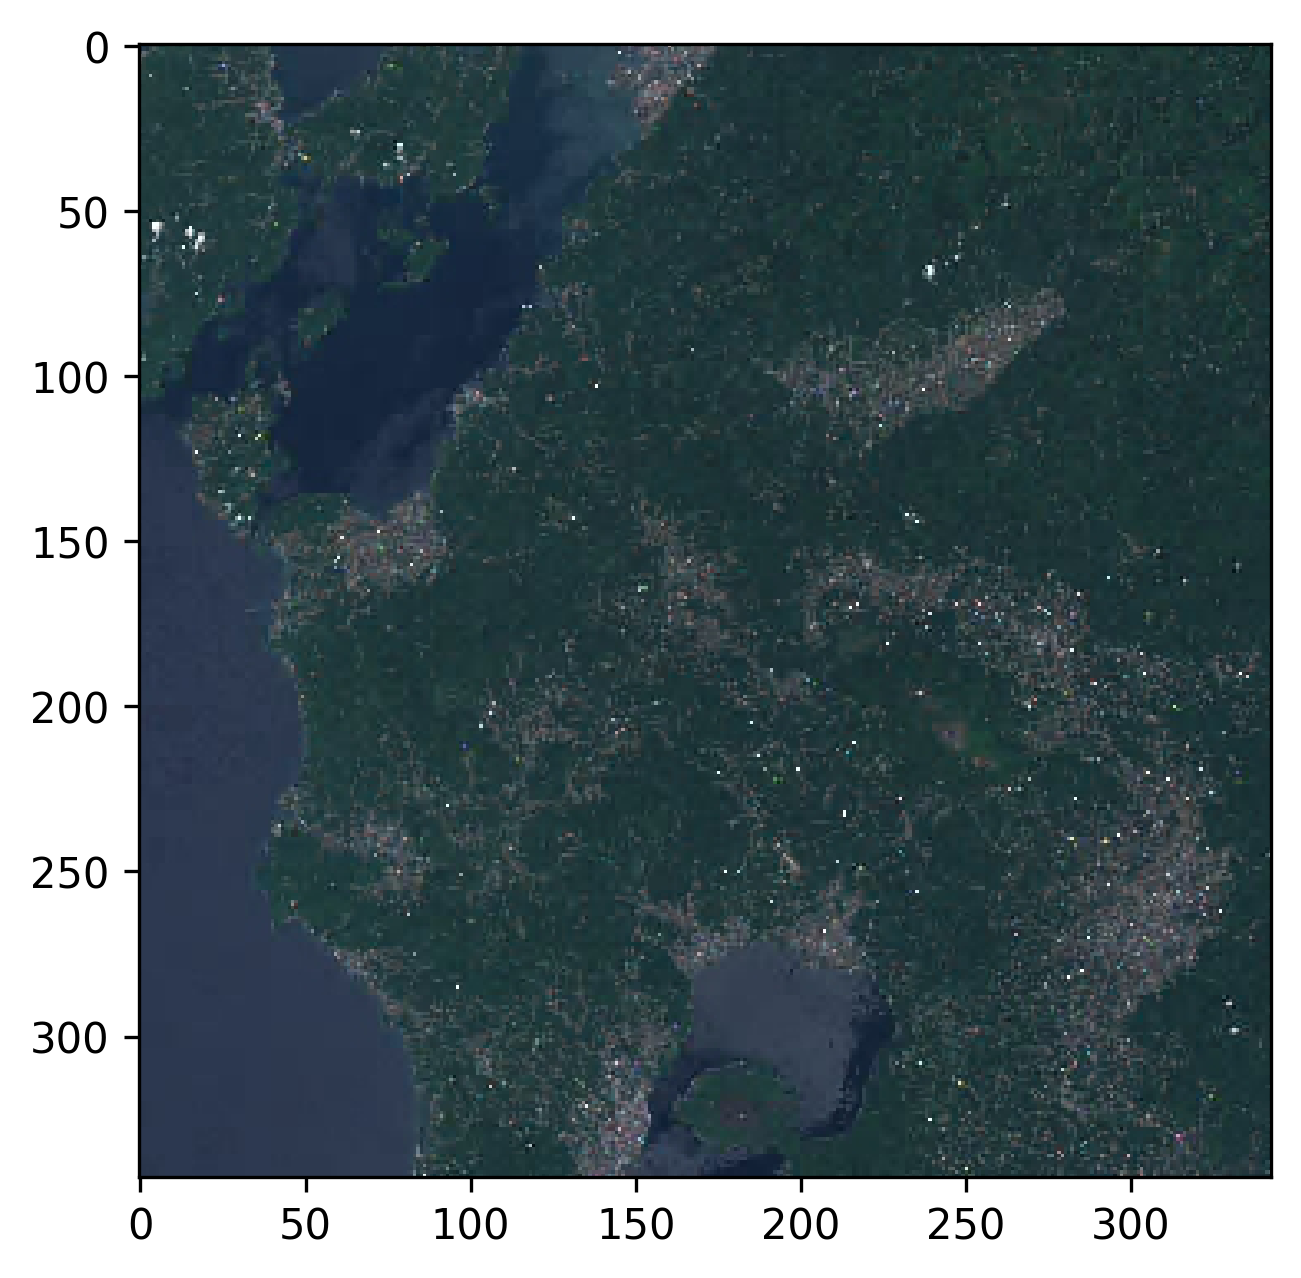

In [ ]:
thumbImg = Image.open(io.BytesIO(requests.get(thumbUrl[0]).content))
plt.figure(figsize=(5,5))
plt.imshow(thumbImg)

画像データはhrefに記載されている場所に保存されていますので、それらを自分の環境へダウンロードしましょう。

In [ ]:
# Sentinel-2のバンド情報を表で示す
import rich.table

table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in selected_item[0].items():
  table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key ┃ Description                     ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ thumbnail │ Thumbnail                       │
│ overview  │ True color image                │
│ info      │ Original JSON metadata          │
│ metadata  │ Original XML metadata           │
│ visual    │ True color image                │
│ B01       │ Band 1 (coastal)                │
│ B02       │ Band 2 (blue)                   │
│ B03       │ Band 3 (green)                  │
│ B04       │ Band 4 (red)                    │
│ B05       │ Band 5                          │
│ B06       │ Band 6                          │
│ B07       │ Band 7                          │
│ B08       │ Band 8 (nir)                    │
│ B8A       │ Band 8A                         │
│ B09       │ Band 9                          │
│ B11       │ Band 11 (swir16)                │
│ B12       │ Band 12 (swir22)                │
│ AOT       │ Aerosol Optical Thickness (AOT) │
│ WVP       │ Water Vapour (WVP)              │
│ SCL       │ Scene Classification Map (SCL)  │
└───────────┴─────────────────────────────────┘

In [ ]:
# URLからファイルをダウンロードする関数を定義
# 引用：https://note.nkmk.me/python-download-web-images/
def download_file(url, dst_path):
    try:
        with urllib.request.urlopen(url) as web_file, open(dst_path, 'wb') as local_file:
            local_file.write(web_file.read())
    except urllib.error.URLError as e:
        print(e)

def download_file_to_dir(url, dst_dir):
    download_file(url, os.path.join(dst_dir, os.path.basename(url)))

In [ ]:
# 画像を保存するディレクトリの作成
os.makedirs('s2Bands',exist_ok=True)

# 取得するバンドの選択
bandLists = ['B11','B08','B04','B03','B02'] # SWIR, NIR, RED, GREEN, BLUE

# 画像のURL取得
file_url = []
[file_url.append(selected_item[0][band].href) for band in bandLists if file_url.append(selected_item[0][band].href) is not None]

# 画像のダウンロード
dst_dir = '/content/s2Bands'
[download_file_to_dir(link, dst_dir) for link in file_url if download_file_to_dir(link, dst_dir) is not None]

[]

ここからは、earthpyとxarrayを用いて説明を行います。

In [ ]:
# ライブラリのインポート
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import xarray as xr
import rioxarray as rxr

まずはデータを読み込みましょう。

In [ ]:
# TIFデータのパス指定
land_paths = glob.glob(os.path.join("/content/s2Bands","*.tif"))
# バンド順に並び替え
land_paths.sort()
land_paths

['/content/s2Bands/B02.tif',
 '/content/s2Bands/B03.tif',
 '/content/s2Bands/B04.tif',
 '/content/s2Bands/B08.tif',
 '/content/s2Bands/B11.tif']

例として近赤外のバンド情報を示してみます。

In [ ]:
b08_href = selected_item[0]["B08"].href
b08 = rxr.open_rasterio(b08_href, masked=True)
print(b08)

<xarray.DataArray (band: 1, y: 10980, x: 10980)>
[120560400 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 3.6e+06 3.6e+06 3.6e+06 ... 3.49e+06 3.49e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0


続いて、実際にデータを描画しますが、TIF画像のデータは重いため、領域を絞って描画します。

国土地理院が公開している国土数値情報のうち行政区域データからダウンロードしましょう。ダウンロードは県単位になるため、鹿児島県から鹿児島市のポリゴンを以下のように抜き出します（平成31年のデータを利用しています）。抜き出したら、ポリゴンの座標系をSentinel-2のデータと同じUTM zone 52N (EPSG:32652) に変換します。

In [ ]:
# 行政区域データをダウンロードするフォルダの作成
os.makedirs('kagoshimaPolygon',exist_ok=True)

# wgetを行う
!wget --restrict-file-names=nocontrol \
     --content-disposition \
     --user-agent="Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:52.0) Gecko/20100101 Firefox/52.0" \
     "https://nlftp.mlit.go.jp/ksj/gml/data/N03/N03-2019/N03-190101_46_GML.zip" \
     -P /content/kagoshimaPolygon

import zipfile

# ダウンロードしたファイルを展開する
with zipfile.ZipFile('/content/kagoshimaPolygon/N03-190101_46_GML.zip') as zipf:
  for zinfo in zipf.infolist():        # ZipInfoオブジェクトを取得
      if not zinfo.flag_bits & 0x800:  # flag_bitsプロパティで文字コードを取得
          # 文字コードが(cp437)だった場合はcp932へ変換する
          # strオブジェクトのプロパティencode/decodeでcp932に変換
          # 変換後のファイル名をfilenameプロパティで再度し直す
          zinfo.filename = zinfo.filename.encode('cp437').decode('cp932')
          if os.sep != "/" and os.sep in zinfo.filename:
            zinfo.filename = zinfo.filename.replace(os.sep, "/")

      zipf.extract(zinfo, '/content/kagoshimaPolygon')

--2022-11-13 07:59:20--  https://nlftp.mlit.go.jp/ksj/gml/data/N03/N03-2019/N03-190101_46_GML.zip
Resolving nlftp.mlit.go.jp (nlftp.mlit.go.jp)... 147.154.116.181, 192.29.107.131, 192.29.105.247
Connecting to nlftp.mlit.go.jp (nlftp.mlit.go.jp)|147.154.116.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20964085 (20M) [application/zip]
Saving to: ‘/content/kagoshimaPolygon/N03-190101_46_GML.zip.1’

N03-190101_46_GML.z 100%[===================>]  19.99M  15.9MB/s    in 1.3s    

2022-11-13 07:59:23 (15.9 MB/s) - ‘/content/kagoshimaPolygon/N03-190101_46_GML.zip.1’ saved [20964085/20964085]



In [ ]:
#ダウンロードしたデータを解凍して、ディレクトリを指定
shape_path = "/content/kagoshimaPolygon/"

# 鹿児島県のshpの読み込み
kagoshimaPref = gpd.read_file(os.path.join(shape_path + "N03-19_46_190101.geojson"),encoding="shift-jis")
kagoshimaCity = kagoshimaPref[kagoshimaPref["N03_004"].isin(["鹿児島市"])] # 鹿児島市でソート
kagoshimaCity = kagoshimaCity.drop(columns=["N03_002","N03_003"]) # 鹿児島市のみを抽出

# 抽出した鹿児島市のポリゴンをSentinel-2のCRSに合わせる
with rio.open(land_paths[0]) as raster_crs:
  raster_profile = raster_crs.profile
  bound_utm52N = kagoshimaCity.to_crs(raster_profile["crs"])

このポリゴンデータを用いて、画像の切り抜きを行います。ダウンロードしたTIF画像の場所を指定と切り抜き後の出力場所、さらに切り抜きを行うためのファイルを指定します。ファイルの上書きを行っても良い場合には、`overwrite`を`True`にしてください（デフォルトは`False`)。

In [ ]:
os.makedirs('s2Output',exist_ok=True) # outputデータ保存ディレクトリ
output_dir = "/content/s2Output"
band_paths_list = es.crop_all(land_paths, output_dir, 
                              bound_utm52N, overwrite=True)

青、赤、緑、そして近赤外の画像データを描画します。

In [ ]:
# ループ処理で全てのバンド情報を開く
allBands = []
for i, aband in enumerate(band_paths_list[0:4]):
    allBands.append(rxr.open_rasterio(aband, masked=True).squeeze())
    # バンド数を新しいxarrayオブジェクトとして割り当てる
    allBands[i]["band"]=i+2

# データリストを一つのxarrayオブジェクトへ変換
s2Kagoshima = xr.concat(allBands, dim="band") 

# xarray.plot.imshowで描画
s2Kagoshima.plot.imshow(col="band",
                        col_wrap=2, # 2列で折り返し
                        figsize=(8,8))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

トゥルーカラー画像を描画します。Rにband4、Gにband3、Bにband2を割り当てます。

In [ ]:
# # xarrayを表示。Coordinates内のbandと示されているところに、どのバンドが含まれているかが示されています
# print(s2Kagoshima)

# xarray中でバンドは2, 3, 4, 5, 6の順番に並んでいますので、RGBの場合には2, 1, 0を割り当てれば良いことがわかります。

ep.plot_rgb(s2Kagoshima.values,
            rgb=[2, 1, 0],
            title="True Color Image")
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

ep.plot_rgb(s2Kagoshima.values,
            rgb=[2, 1, 0],
            ax = ax,
            title="True Color Image\n Linear Stretch Applied",
            stretch=True,
            str_clip = 0.08)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

引き延ばしを行わない場合に比べて、格段に見やすくなっています。

続いて、Color Infrared (CIR)合成画像を出力してみましょう。CIRは植生を強調するための組み合わせになります。こちらでは、Rに近赤外、Gに赤の波長、Bに緑の波長を割り当てます。植物は近赤外をよく反射するため、赤い場所ほど、植物が繁茂している状態だとわかります。裸地は黒から明るい褐色、都市部は、青、もしくは灰色っぽく呈色されます。雲や雪、氷は明るい青色や白色になることが多いです。

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# NIR、赤、緑を組み合わせる
ep.plot_rgb(
    s2Kagoshima.values,
    rgb=(3, 2, 1),
    ax=ax,
    stretch=True,
    str_clip=0.02,
    title="CIR Image with Stretch Applied",
)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

緑で被覆されている部分が赤く抵触されていることがわかります。桜島を見ると、火口の周辺には全く植生が存在せず、島を囲うように植物が生い茂っているようです。

画像の切り抜き方法については、他にも方法があります。`earthpy`の`crop_all`はポリゴンデータの最大最小座標を読み取り、切り抜く方法のため、ポリゴンの形をそのままで抜き出すわけではありません。しかし、その分処理が高速です。ポリゴンに沿って切り抜きを行いたい場合には、rasterioや、gdalを用いることになります。厳密な切り抜き処理には、時間がかかります。そのため切り抜きに用いるポリゴン自体をシンプルな形状に変換し、切り抜き処理を高速化することがあります。

In [ ]:
cropped_array, array_raster_profile = es.stack(band_paths_list[0:4], nodata=-9999) # データが存在しない場所に-9999を入れます
crop_extent = plotting_extent(
    cropped_array[0], array_raster_profile["transform"] # 切り抜き範囲（描画範囲）とアフィン変換の指定
    )

In [ ]:
# TRUEとCIRの合成画像を並べて表示
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

# 切り抜き後の画像を出力 (TRUE)
ax1 = ep.plot_rgb(
    cropped_array,
    rgb=(2,1,0),
    ax=ax1,
    stretch=True,
    extent=crop_extent,
    title="Cropped Raster\n (TRUE Composite)",
)

# 切り抜き後の画像を出力 (CIR)
ax2= ep.plot_rgb(
    cropped_array,
    rgb=(3,2,1),
    ax=ax2,
    stretch=True,
    extent=crop_extent,
    title="Cropped Raster\n (CIR Composite)",
)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
ndvi = (s2Kagoshima[3] - s2Kagoshima[2]) / (s2Kagoshima[3] + s2Kagoshima[2])
ndviImage = rio.open('ndvi.tiff','w',
                     driver='Gtiff',
                     width=s2Kagoshima[2].rio.width,
                     height = s2Kagoshima[2].rio.height,
                     count=1, crs=s2Kagoshima[2].rio.crs,
                     transform=s2Kagoshima[2].rio.transform(),
                     dtype='float64')
ndviImage.write(ndvi,1)
ndviImage.close()

In [ ]:
# 緑の濃い部分ほど、植物が繁茂し、赤色が強いほど、植生がない状態を示します
ndviTif = rio.open('ndvi.tiff')
fig = plt.figure(figsize=(8,8))
plot.show(ndviTif, cmap="RdYlGn")

Output hidden; open in https://colab.research.google.com to view.

MNDWI = (Green – SWIR) / (Green + SWIR)の式となります。Sentinel-2であれば、band3とband11を利用することになります。

MNDWI = (Band 3 – Band 11) / (Band 3 + Band 11)

通常、海や河川は0.5辺りの値となり、植物に含まれる水分はそれより低くなる傾向があるため、分離はし易いことが知られています。また市街地もプラス寄りの値をとることが多いです。

In [ ]:
# ファイルの場所は適宜変更
b3 = gdal.Open("/content/s2Output/B03_crop.tif")

# resample 10m->20m
# 現在の作業ディレクトリにファイルを保存
dsRes = gdal.Warp("content/s2Output/B03_crop_avg.tif", b3, xRes = 20, yRes = 20, resampleAlg = "average")

In [ ]:
b3 = rio.open("/content/s2Output/B03_crop_avg.tif")
b11 = rio.open("/content/s2Output/B11_crop.tif")
green = b3.read(1).astype('float64')
swir = b11.read(1).astype('float64')


mndwi = es.normalized_diff(b1=green, b2=swir) # GreenとSWIRの波長を抽出し、正規化します
ep.plot_bands(mndwi, cmap="RdYlBu", cols=1, title="Modified Normalized Difference Water Index (MNDWI)")
# ep.plot_bands(mndwi, cmap="RdYlBu", cols=1, title="Modified Normalized Difference Water Index (MNDWI)",vmin=-1,vmax=1)

Output hidden; open in https://colab.research.google.com to view.